# ML Analysis - Система автоматической оценки экзаменов по русскому языку

Этот notebook объединяет функциональность обработки CSV файлов и машинного обучения для анализа и экспериментов.

код включает два разных файла в компиляции

* backend\handlers\csv_handler.py

* backend\services\ml_service.py

* ml_models\training\train_model.py

Файл создан для:

* Исследовательского анализа данных

* Экспериментов с моделями

* Визуализации результатов

* Отладки алгоритмов

## Импорты и настройки

In [105]:
# !pip install mutagen

In [106]:

import pandas as pd
import numpy as np
import pickle
import re
import io
import os
from typing import List, Dict, Any
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings
import tempfile
import time
from datetime import datetime
import pymorphy3
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer 
from phik import phik_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from mutagen.mp3 import MP3
import io
import aiohttp
import asyncio
import nest_asyncio
from collections import Counter

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score



In [107]:
warnings.filterwarnings('ignore') # чтобы не было красный полей с предупреждениями об устаревших библиотеках

%matplotlib inline
plt.ion() # принудительное отображение графиков matplotlib в VS Code
# display(HTML("<style>.container { width:90% !important; }</style>")) # чтобы листик в джупитре был пошире - не работает
pd.set_option("display.max_columns", None) # чтобы сам df был пошире
# pd.set_option('display.max_colwidth', None) # чтобы df колонки были пошире
pd.set_option('display.float_format', '{:.2f}'.format) # округление чисел в df, чтобы числа не печатал экспоненциально
pd.options.display.expand_frame_repr = False # для принта чтобы колонки не переносил рабоатет тольок в vs code, in jupyter notebook получается каша

# plt.style.use('dark_background') # темная тема на графиках - график черный, остальной лист белый
# sns.set_style('darkgrid') # темная тема на графиках - график черный, остальной лист белый

In [108]:
path = r'C:\Users\dmi-a\OneDrive\Рабочий стол\DS учеба\Выполненные проекты\rus_exam_site\docs\Данные для кейса.csv'

df = pd.read_csv(path, delimiter=';', encoding='utf-8')

Нужно произвести очистку и нормализацию текста

In [109]:
def clean_text(text):
    """Полная очистка текста"""
    if pd.isna(text):
        return text
    
    text = str(text)
    text = re.sub(r'<[^>]+>', '', text)  # HTML теги
    text = text.replace('\n', ' ')        # Переносы строк
    text = re.sub(r'\s+', ' ', text)      # Множественные пробелы
    text = text.strip()                   # Пробелы в начале/конце
    
    return text

df['Текст вопроса'] = df['Текст вопроса'].apply(clean_text)

df.sample(2)

,Id экзамена,Id вопроса,№ вопроса,Текст вопроса,Картинка из вопроса,Оценка экзаменатора,Транскрибация ответа,Ссылка на оригинальный файл запис
5731,3414103,31369142,3,Вопрос устной части экзамена. Начните диалог. ...,NaN,1,Внимательно ознакомьтесь с ней и начните делат...,https://storage.yandexcloud.net/odin-exam-file...
4479,3405302,31209470,1,Добро пожаловать на экзамен! Вопрос устной час...,NaN,1,"Первый вопрос, вам нужно начать диалог. Вы заб...",https://storage.yandexcloud.net/odin-exam-file...


для теста возьмем только любые 30 строк датасета

In [110]:
# df = df.sample(4000)

Алгоритм должен анализировать текст вопроса и предсказывать оценку экзаменатора. 
я бы создал дополнительные колонки в датасете с признаками коэфициентами, которые будут образованы при анализе датафрейма:
 если в ответе повторяется текст на половину или более из колонки с вопросов - это пониажающий фактор
 Если объем ответа меньше чем средний объем ответов - это понимажающий фактор, если объем ответа больше, чем средний объем ответа - это повышающий фактор.
 Попытаться определить пол человека, ответ которого присутсвует в транскрибации ответа. Если он в 30 процентах случаев и более неправильно использует пол - это понимажающий фактор.
 Надо узнать какой длины аудио файлы в колонке "Ссылка на оригинальный файл записи", вычислить среднюю длину файла. при следующем соотношении: длина текста в столбце Транскрибация ответа больше среднего и длины аудидо файл в столбце "Ссылка на оригинальный файл записи" меньше среднего в совокупности это повышающий коэффициент, если наоборот, то понижающий.

In [111]:
# скачиваем аудиофайл, замеряем его длину

start_time = time.time() 

# так в два раза дольше, но при асинхронном скачивании файла выходит ошибка таймаута

def process_audio_durations_sync(df):
    """Синхронная обработка аудио файлов"""
    counter = 0  # Перенести внутрь функции
    len_df = len(df)
    
    def get_audio_duration_sync(url):
        nonlocal counter  # Доступ к переменной из внешней функции
        try:
            response = requests.get(url, timeout=30)
            content = response.content
            duration = max(5, min(len(content) / 16000, 700))
            counter += 1
            print(f'{counter} файл из {len_df}.. прогресс: {(counter / len_df * 100):.1f}%: Длина файла {duration / 60:.1f} мин')
            return duration
        except Exception as e:
            counter += 1
            print(f"Ошибка {counter}/{len_df}: {type(e).__name__}")
            return 60
    
    if 'Ссылка на оригинальный файл запис' in df.columns:
        print("Начинаем скачивать каждый аудиофайл...")
        df['Длина_файла'] = df['Ссылка на оригинальный файл запис'].apply(get_audio_duration_sync)
    else:
        df['Длина_файла'] = 0
    
    return df

# Использование
df = process_audio_durations_sync(df)
duration = time.time() - start_time
print(f"⏱️ Время выполнения: {len(df)} файлов за {duration:.2f} секунд")

Начинаем скачивать каждый аудиофайл...
1 файл из 9798.. прогресс: 0.0%: Длина файла 2.0 мин
2 файл из 9798.. прогресс: 0.0%: Длина файла 3.1 мин
3 файл из 9798.. прогресс: 0.0%: Длина файла 5.1 мин
4 файл из 9798.. прогресс: 0.0%: Длина файла 10.7 мин
5 файл из 9798.. прогресс: 0.1%: Длина файла 2.7 мин
6 файл из 9798.. прогресс: 0.1%: Длина файла 8.3 мин
7 файл из 9798.. прогресс: 0.1%: Длина файла 7.9 мин
8 файл из 9798.. прогресс: 0.1%: Длина файла 5.6 мин
9 файл из 9798.. прогресс: 0.1%: Длина файла 3.9 мин
10 файл из 9798.. прогресс: 0.1%: Длина файла 6.8 мин
11 файл из 9798.. прогресс: 0.1%: Длина файла 9.1 мин
12 файл из 9798.. прогресс: 0.1%: Длина файла 6.3 мин
13 файл из 9798.. прогресс: 0.1%: Длина файла 2.7 мин


KeyboardInterrupt: 

In [ ]:
df.to_csv('df.csv', index=False, encoding='utf-8', sep=';')


# **ПЕРЕЗАПУСКАТЬСЯ ОТСЮДА**

In [191]:
df = pd.read_csv('df.csv', delimiter=';', encoding='utf-8')

Предобработка данных

In [192]:
len(df)

9792

### **Предобработка данных**

кол-во испорченных строк

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9792 entries, 0 to 9791
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Id экзамена                        9792 non-null   int64  
 1   Id вопроса                         9792 non-null   int64  
 2   № вопроса                          9792 non-null   int64  
 3   Текст вопроса                      9792 non-null   object 
 4   Картинка из вопроса                2436 non-null   object 
 5   Оценка экзаменатора                9792 non-null   int64  
 6   Транскрибация ответа               9792 non-null   object 
 7   Ссылка на оригинальный файл запис  9792 non-null   object 
 8   Длина_файла                        9792 non-null   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 688.6+ KB


In [196]:
# Удаляем строки с 6 и более точками подряд
df = df[df['Транскрибация ответа'].str.contains(r'[а-яёa-z]', case=False, na=False)]

In [197]:
df = df.drop(['Id экзамена', 'Id вопроса', 'Ссылка на оригинальный файл запис', 'Картинка из вопроса'], axis=1)

In [198]:
len(df)

9791

In [199]:
df.head(3)

,№ вопроса,Текст вопроса,Оценка экзаменатора,Транскрибация ответа,Длина_файла
0,1,Добро пожаловать на экзамен! Вопрос устной час...,1,Ваше первое задание. Вам нужно начать диалог. ...,117.03
1,2,Вопрос устной части экзамена. Примите участие ...,2,Теперь вам нужно принять участие в диалоге. От...,184.14
2,3,Вопрос устной части экзамена. Начните диалог. ...,1,"Получите нужную вам информацию, будьте вежливы...",307.07


In [200]:
def calculate_complexity(pos_counts, total_words):
    """Расчет сложности речи"""
    # Сложные части речи дают больше баллов
    complexity_weights = {
        'ADJF': 1.6,  # прилагательные
        'ADVB': 1.8,  # наречия
        'GRND': 1.9,  # деепричастия
        'PREP': 1.2,  # предлоги
        'CONJ': 1.1,  # союзы
        'VERB': 1.4,  # глаголы
        'INFN': 1.3,  # инфинитивы
        'PRTF': 1.5,  # причастия
        'PRTS': 1.5   # причастия
    }
    
    complexity = 0
    for pos, count in pos_counts.items():
        weight = complexity_weights.get(pos, 1.0)
        complexity += (count / total_words) * weight
    
    return min(complexity, 1)

In [201]:
df.shape

(9791, 5)

In [202]:
def detect_grammar_errors(text):
    """Поиск грамматических ошибок"""
    errors = 0
    text_lower = text.lower()
    
    # Ошибки согласования рода
    gender_patterns = [
        # Местоимения с глаголами
        r'я\s+(пошел|сделал|купил).*была',
        r'я\s+(пошла|сделала|купила).*был',
        r'он\s+(пошла|сделала|купила)',
        r'она\s+(пошел|сделал|купил)',
        
        # Числительные с существительными
        r'много\s+(студент|учитель|врач)\b',
        r'(пять|шесть|семь|восемь|девять)\s+(стол|дом|человек)\b',
        r'(два|три|четыре)\s+(девочка|женщина|мама)\b',
        
        # Прилагательные с существительными
        r'красивый\s+(девочка|мама|тетя)',
        r'красивая\s+(мальчик|папа|дядя)',
        r'большой\s+(комната|кухня|школа)',
        r'большая\s+(дом|стол|класс)',
        
        # Притяжательные местоимения
        r'мой\s+(мама|сестра|бабушка)',
        r'моя\s+(папа|брат|дедушка)',
        r'наш\s+(семья|группа|команда)',
        r'наша\s+(класс|дом|город)',
        
        # Ошибки падежей
        r'в\s+(школа|дом|магазин)\b',  # должно быть "в школе"
        r'из\s+(школа|дом|магазин)\b', # должно быть "из школы"
        r'к\s+(мама|папа|врач)\b',     # должно быть "к маме"
    ]
    
    for pattern in gender_patterns:
        matches = len(re.findall(pattern, text_lower))
        errors += matches
    
    return min(errors / 15, 1)*-10  # нормализуем 0-1

In [203]:
# !pip install pymorphy3

def analyze_speech_quality(text):
    """Анализ качества речи через морфологию"""
    # Проверка на пустой текст
    
    morph = pymorphy3.MorphAnalyzer()
    
    # Очистка текста
    words = re.findall(r'\b\w+\b', str(text).lower()) # удаляет знаки препинания, цифры, спецсимволы, множественные пробелы, скобки
    
    # Анализ каждого слова
    pos_counts = Counter()
    unique_lemmas = set()
    
    for word in words:
        parsed = morph.parse(word)[0]
        
        # Подсчет частей речи
        if parsed.tag.POS:
            pos_counts[parsed.tag.POS] += 1
        
        # Уникальные леммы (словарный запас)
        unique_lemmas.add(parsed.normal_form)
    
    # if len(unique_lemmas) == 0:
    #     display(df[df['Транскрибация ответа'] == text])

    total_words = len(words)

    # Критерии качества речи
    lexical_diversity = len(unique_lemmas) / total_words if total_words > 0 else 0
    noun_ratio = pos_counts.get('NOUN', 0) / total_words
    NOUN = pos_counts.get('NOUN', 0)
    verb_ratio = pos_counts.get('VERB', 0) / total_words
    # VERB = pos_counts.get('VERB', 0) / total_words
    adjective_ratio = pos_counts.get('ADJF', 0) / total_words
    ADJF = pos_counts.get('ADJF', 0)
    # grnd_ratio = pos_counts.get('GRND', 0) / total_words # GRND - деепричастие
    # GRND = pos_counts.get('GRND', 0)
    # PRTF_ratio = pos_counts.get('PRTF', 0) / total_words
    # PRTF = pos_counts.get('PRTF', 0)
    # PRTS_ratio = pos_counts.get('PRTS', 0) / total_words # PRTS - причастие краткое
    # PRTS = pos_counts.get('PRTS', 0)

    
    
    # Сложность речи
    complexity_score = calculate_complexity(pos_counts, total_words)
    
    # Итоговая оценка качества (0-10)
    quality_score = (
                    (lexical_diversity) * 2.5 +           # низкое разнообразие = плохо
                    max(2 - verb_ratio * 10, 0) +             # мало глаголов = плохо  
                    max(2 - noun_ratio * 8, 0) +              # мало существительных = плохо
                    (1 - adjective_ratio) * 1.5 +             # мало прилагательных = плохо
                    (1 - complexity_score) * 2                # низкая сложность = плохо
    )

    return {
        'Качество_речи': quality_score,
        'Лексическое_разнообразие': lexical_diversity,
        'Словарный_запас': len(unique_lemmas),
        # 'noun_ratio': noun_ratio,
        # 'verb_ratio': verb_ratio,
        # 'adjective_ratio': adjective_ratio,
        # 'grnd_ratio': grnd_ratio,
        # 'PRTF_ratio': PRTF_ratio,
        # 'PRTS_ratio': PRTS_ratio,
        'NOUN': NOUN,
        # 'VERB': VERB,
        'ADJF': ADJF,
        # 'GRND': GRND,
        # 'PRTF': PRTF,
        # 'PRTS': PRTS,

    }


# Применение к колонке df['Транскрибация ответа']
print("Анализируем качество речи в колонке 'Транскрибация ответа'...")

# Анализ каждого ответа
speech_analysis = df['Транскрибация ответа'].apply(analyze_speech_quality)

# Извлекаем признаки
# df['Качество_речи'] = speech_analysis.apply(lambda x: x['Качество_речи'])
# df['Лексическое_разнообразие'] = speech_analysis.apply(lambda x: x['Лексическое_разнообразие'])
df['Словарный_запас'] = speech_analysis.apply(lambda x: x['Словарный_запас'])
# df['noun_ratio'] = speech_analysis.apply(lambda x: x['noun_ratio'])
# df['verb_ratio'] = speech_analysis.apply(lambda x: x['verb_ratio'])
# df['adjective_ratio'] = speech_analysis.apply(lambda x: x['adjective_ratio'])
df['NOUN'] = speech_analysis.apply(lambda x: x['NOUN'])
# df['VERB'] = speech_analysis.apply(lambda x: x['VERB'])
df['ADJF'] = speech_analysis.apply(lambda x: x['ADJF'])
# df['GRND'] = speech_analysis.apply(lambda x: x['GRND'])
# df['PRTF'] = speech_analysis.apply(lambda x: x['PRTF'])
# df['PRTS'] = speech_analysis.apply(lambda x: x['PRTS'])
# df['Грамматические_ошибки'] = df['Транскрибация ответа'].apply(lambda text: detect_grammar_errors(str(text)))


Анализируем качество речи в колонке 'Транскрибация ответа'...


In [ ]:
df.shape

In [ ]:
def create_advanced_features(df):
    def text_overlap_ratio(row):
        question = str(row['Текст вопроса']).lower()
        answer = str(row['Транскрибация ответа']).lower()
        
        question_words = set(question.split())
        answer_words = set(answer.split())
        
        if len(question_words) == 0:
            return 0
        
        overlap = len(question_words.intersection(answer_words))
        return overlap / len(question_words)
    
    df['question_overlap_ratio'] = df.apply(text_overlap_ratio, axis=1)
    # df['Рассуждение'] = (df['question_overlap_ratio'] >= 0.5).astype(int)
    
    df['Длина_ответа'] = df['Транскрибация ответа'].str.len()
    avg_length = df['Длина_ответа'].mean()
    
    df['length_ratio'] = df['Длина_ответа'] / avg_length
    # df['length_factor'] = np.where(df['length_ratio'] > 1, 1, -1)
    
    df['Скорость_речи'] = df['Длина_ответа'] / df['Длина_файла']
    
    # 2. Исправить подсчет уникальных слов
    df['Уникальных_слов'] = df['Транскрибация ответа'].apply(lambda x: len(set(str(x).split())))
    
    # df['Свобода_речи'] = df['Уникальных_слов'] / df['Длина_ответа']
    
    df['quality_score'] = (
        -df['Рассуждение'] * 1.5 +
        df['length_factor'] * 1.5 +
        df['Скорость_речи'] * 1.5
    ) + 5
    
    return df.sample()

create_advanced_features(df)

,№ вопроса,Текст вопроса,Оценка экзаменатора,Транскрибация ответа,Длина_файла,Качество_речи,Лексическое_разнообразие,Словарный_запас,noun_ratio,verb_ratio,adjective_ratio,NOUN,VERB,ADJF,GRND,PRTF,PRTS,Грамматические_ошибки,question_overlap_ratio,Рассуждение,Длина_ответа,length_ratio,length_factor,Скорость_речи,Уникальных_слов,Свобода_речи,quality_score
0,1,Добро пожаловать на экзамен! Вопрос устной час...,1,Ваше первое задание. Вам нужно начать диалог. ...,60,3.44,0.61,53,0.20,0.20,0.05,17,0.20,4,0,0,0,-0.00,0.67,1,535,0.40,-1,8.92,69,0.13,15.38
1,2,Вопрос устной части экзамена. Примите участие ...,2,Теперь вам нужно принять участие в диалоге. От...,60,3.51,0.61,52,0.27,0.14,0.07,23,0.14,6,0,0,0,-0.00,0.76,1,511,0.38,-1,8.52,67,0.13,14.78
2,3,Вопрос устной части экзамена. Начните диалог. ...,1,"Получите нужную вам информацию, будьте вежливы...",60,3.44,0.59,75,0.23,0.15,0.11,30,0.15,14,0,1,0,-0.67,0.82,1,972,0.72,-1,16.20,96,0.10,26.30
3,4,Вопрос устной части экзамена. Опишите картинку...,2,"Описывать можно не сразу, можно рассмотреть, п...",60,3.19,0.39,323,0.25,0.12,0.09,204,0.12,76,0,1,5,-0.00,0.62,1,5006,3.73,1,83.43,509,0.10,130.15
4,1,Добро пожаловать на экзамен! Вопрос устной час...,1,Первый вопрос – это вам нужно начать диалог. В...,60,3.58,0.66,52,0.23,0.15,0.15,18,0.15,12,0,0,0,-0.00,0.56,1,555,0.41,-1,9.25,66,0.12,15.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9787,3,Вопрос устной части экзамена. Начните диалог. ...,0,"Начните диалог, получите нужную Вам информацию...",60,3.75,0.63,69,0.22,0.15,0.08,24,0.15,9,0,1,0,-0.00,0.81,1,803,0.60,-1,13.38,86,0.11,22.07
9788,4,Вопрос устной части экзамена. Опишите картинку...,1,Следующее задание. Задание 4. Опишите картинку...,60,3.32,0.48,275,0.26,0.12,0.10,151,0.12,60,0,1,4,-0.00,0.73,1,3620,2.70,1,60.33,392,0.11,95.50
9789,1,Добро пожаловать на экзамен! Вопрос устной час...,0,"Познакомьтесь, пожалуйста, с первым заданием. ...",60,3.57,0.64,85,0.27,0.14,0.07,36,0.14,9,0,0,2,-0.00,0.67,1,916,0.68,-1,15.27,109,0.12,24.90
9790,2,Вопрос устной части экзамена. Примите участие ...,2,"Задание 2. Ответьте, пожалуйста, на мои вопрос...",60,3.34,0.64,84,0.26,0.15,0.16,34,0.15,21,0,0,0,-0.00,0.69,1,871,0.65,-1,14.52,110,0.13,23.78


**Дополнительный Feature Enginering на основе силы корреляции**

In [ ]:
# Комбинации сильных предикторов
df['vocab_adjf'] = df['Словарный_запас'] * df['ADJF']
df['length_quality'] = df['Длина_ответа'] * df['quality_score']
df['question_vocab'] = df['№ вопроса'] * df['Словарный_запас']

Переименуем столбцы, потом группировку

In [ ]:
df.sample()

,№ вопроса,Текст вопроса,Оценка экзаменатора,Транскрибация ответа,Длина_файла,Качество_речи,Лексическое_разнообразие,Словарный_запас,noun_ratio,verb_ratio,adjective_ratio,NOUN,VERB,ADJF,GRND,PRTF,PRTS,Грамматические_ошибки,question_overlap_ratio,Рассуждение,Длина_ответа,length_ratio,length_factor,Скорость_речи,Уникальных_слов,Свобода_речи,quality_score
1358,1,Вопрос устной части экзамена. Начните диалог. ...,1,Какие перечень документов нужны для оформления...,60,4.37,0.59,57,0.22,0.08,0.02,21,0.08,2,0,1,0,-0.00,0.38,0,599,0.45,-1,9.98,74,0.12,18.47


In [ ]:
df.columns

Index(['№ вопроса', 'Текст вопроса', 'Оценка экзаменатора',
       'Транскрибация ответа', 'Длина_файла', 'Качество_речи',
       'Лексическое_разнообразие', 'Словарный_запас', 'noun_ratio',
       'verb_ratio', 'adjective_ratio', 'NOUN', 'VERB', 'ADJF', 'GRND', 'PRTF',
       'PRTS', 'Грамматические_ошибки', 'question_overlap_ratio',
       'Рассуждение', 'Длина_ответа', 'length_ratio', 'length_factor',
       'Скорость_речи', 'Уникальных_слов', 'Свобода_речи', 'quality_score'],
      dtype='object')

Сделаем группировку по целевому признаку и посмотрим как что характеризует каждую оценку.

In [ ]:
df.head(1)

,№ вопроса,Текст вопроса,Оценка экзаменатора,Транскрибация ответа,Длина_файла,Качество_речи,Лексическое_разнообразие,Словарный_запас,noun_ratio,verb_ratio,adjective_ratio,NOUN,VERB,ADJF,GRND,PRTF,PRTS,Грамматические_ошибки,question_overlap_ratio,Рассуждение,Длина_ответа,length_ratio,length_factor,Скорость_речи,Уникальных_слов,Свобода_речи,quality_score
0,1,Добро пожаловать на экзамен! Вопрос устной час...,1,Ваше первое задание. Вам нужно начать диалог. ...,60,3.44,0.61,53,0.20,0.20,0.05,17,0.20,4,0,0,0,-0.00,0.67,1,535,0.40,-1,8.92,69,0.13,15.38


In [ ]:
df.groupby('Оценка экзаменатора').agg({
    # 'Качество_речи': ['mean'],
    'Лексическое_разнообразие': ['mean'],
    'Словарный_запас': ['mean'],
    'Скорость_речи': ['mean'],
    # 'Рассуждение': ['mean'],
    'Длина_ответа': ['mean'],
    # 'Грамматические_ошибки': ['mean'],
    # 'noun_ratio': ['mean'],
    'NOUN': ['mean'], 
    # 'verb_ratio': ['mean'], 
    # 'VERB': ['mean'], 
    # 'adjective_ratio': ['mean'],
    'ADJF': ['mean'], 
    # 'GRND': ['mean'], 
    # 'PRTF': ['mean'],
    # 'PRTS': ['mean'],
    # 'question_overlap_ratio': ['mean'],
    'length_ratio': ['mean'],
    # 'length_factor': ['mean'],
    'Уникальных_слов': ['mean'],
    # 'Свобода_речи': ['mean'],
    'quality_score': ['mean'],
    'vocab_adjf': ['mean'],
    'length_quality': ['mean'],
    'question_vocab': ['mean']
})

,Качество_речи,Лексическое_разнообразие,Словарный_запас,Скорость_речи,Рассуждение,Длина_ответа,Грамматические_ошибки,noun_ratio,NOUN,verb_ratio,VERB,adjective_ratio,ADJF,GRND,PRTF,PRTS,question_overlap_ratio,length_ratio,length_factor,Уникальных_слов,Свобода_речи,quality_score
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Оценка экзаменатора,,,,,,,,,,,,,,,,,,,,,,
0,3.89,0.63,71.19,13.55,0.56,812.71,-0.04,0.23,28.55,0.14,0.14,0.08,10.00,0.04,0.44,0.38,0.52,0.61,-0.78,92.86,0.12,23.31
1,3.82,0.60,93.32,18.47,0.65,1108.46,-0.04,0.23,39.52,0.13,0.13,0.09,15.30,0.08,0.55,0.48,0.57,0.83,-0.53,125.85,0.12,30.94
2,3.56,0.51,149.63,32.31,0.69,1938.54,-0.03,0.24,71.33,0.13,0.13,0.10,31.23,0.27,0.58,1.16,0.58,1.45,0.33,212.83,0.11,52.92


In [ ]:
interval_cols = ['Длина_файла', 'Качество_речи',
       'Лексическое_разнообразие', 'Словарный_запас', 'noun_ratio',
       'verb_ratio', 'adjective_ratio', 'grnd_ratio', 'PRTF_ratio',
       'PRTS_ratio', 'NOUN', 'VERB', 'ADJF', 'GRND', 'PRTF', 'PRTS',
       'Грамматические_ошибки', 'question_overlap_ratio', 'Рассуждение',
       'Длина_ответа', 'length_ratio', 'length_factor', 'Скорость_речи',
       'Уникальных_слов', 'Свобода_речи', 'quality_score', 'vocab_adjf', 'length_quality', 'question_vocab']

phik_corr = df.phik_matrix(interval_cols=interval_cols)
phik_corr    

,№ вопроса,Текст вопроса,Оценка экзаменатора,Транскрибация ответа,Качество_речи,Лексическое_разнообразие,Словарный_запас,noun_ratio,verb_ratio,adjective_ratio,NOUN,VERB,ADJF,GRND,PRTF,PRTS,Грамматические_ошибки,question_overlap_ratio,Рассуждение,Длина_ответа,length_ratio,length_factor,Скорость_речи,Уникальных_слов,Свобода_речи,quality_score
№ вопроса,1.00,1.00,0.51,0.00,0.37,0.55,0.67,0.13,0.15,0.49,0.70,0.15,0.62,0.29,0.25,0.59,0.15,0.44,0.36,0.66,0.66,0.81,0.66,0.67,0.24,0.66
Текст вопроса,1.00,1.00,0.73,0.97,0.49,0.57,0.66,0.38,0.45,0.63,0.68,0.45,0.63,0.31,0.30,0.59,0.57,0.53,0.32,0.65,0.65,0.76,0.65,0.66,0.54,0.65
Оценка экзаменатора,0.51,0.73,1.00,0.88,0.33,0.45,0.50,0.25,0.17,0.29,0.52,0.17,0.55,0.31,0.16,0.27,0.03,0.28,0.05,0.50,0.50,0.28,0.50,0.51,0.28,0.49
Транскрибация ответа,0.00,0.97,0.88,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Качество_речи,0.37,0.49,0.33,1.00,1.00,0.69,0.44,0.52,0.51,0.31,0.49,0.51,0.37,0.05,0.04,0.18,0.05,0.52,0.39,0.42,0.42,0.40,0.42,0.43,0.58,0.40
Лексическое_разнообразие,0.55,0.57,0.45,1.00,0.69,1.00,0.72,0.47,0.33,0.27,0.73,0.33,0.68,0.19,0.17,0.45,0.12,0.60,0.33,0.77,0.77,0.87,0.77,0.76,0.71,0.76
Словарный_запас,0.67,0.66,0.50,1.00,0.44,0.72,1.00,0.30,0.23,0.23,0.92,0.23,0.85,0.31,0.26,0.55,0.17,0.55,0.26,0.94,0.94,0.99,0.94,0.96,0.39,0.94
noun_ratio,0.13,0.38,0.25,1.00,0.52,0.47,0.30,1.00,0.34,0.30,0.19,0.34,0.15,0.00,0.02,0.13,0.00,0.47,0.22,0.18,0.18,0.16,0.18,0.23,0.65,0.17
verb_ratio,0.15,0.45,0.17,1.00,0.51,0.33,0.23,0.34,1.00,0.21,0.19,1.00,0.16,0.00,0.00,0.06,0.02,0.27,0.15,0.18,0.18,0.15,0.18,0.20,0.29,0.17
adjective_ratio,0.49,0.63,0.29,1.00,0.31,0.27,0.23,0.30,0.21,1.00,0.21,0.21,0.34,0.03,0.04,0.10,0.05,0.23,0.14,0.20,0.20,0.27,0.20,0.22,0.22,0.20


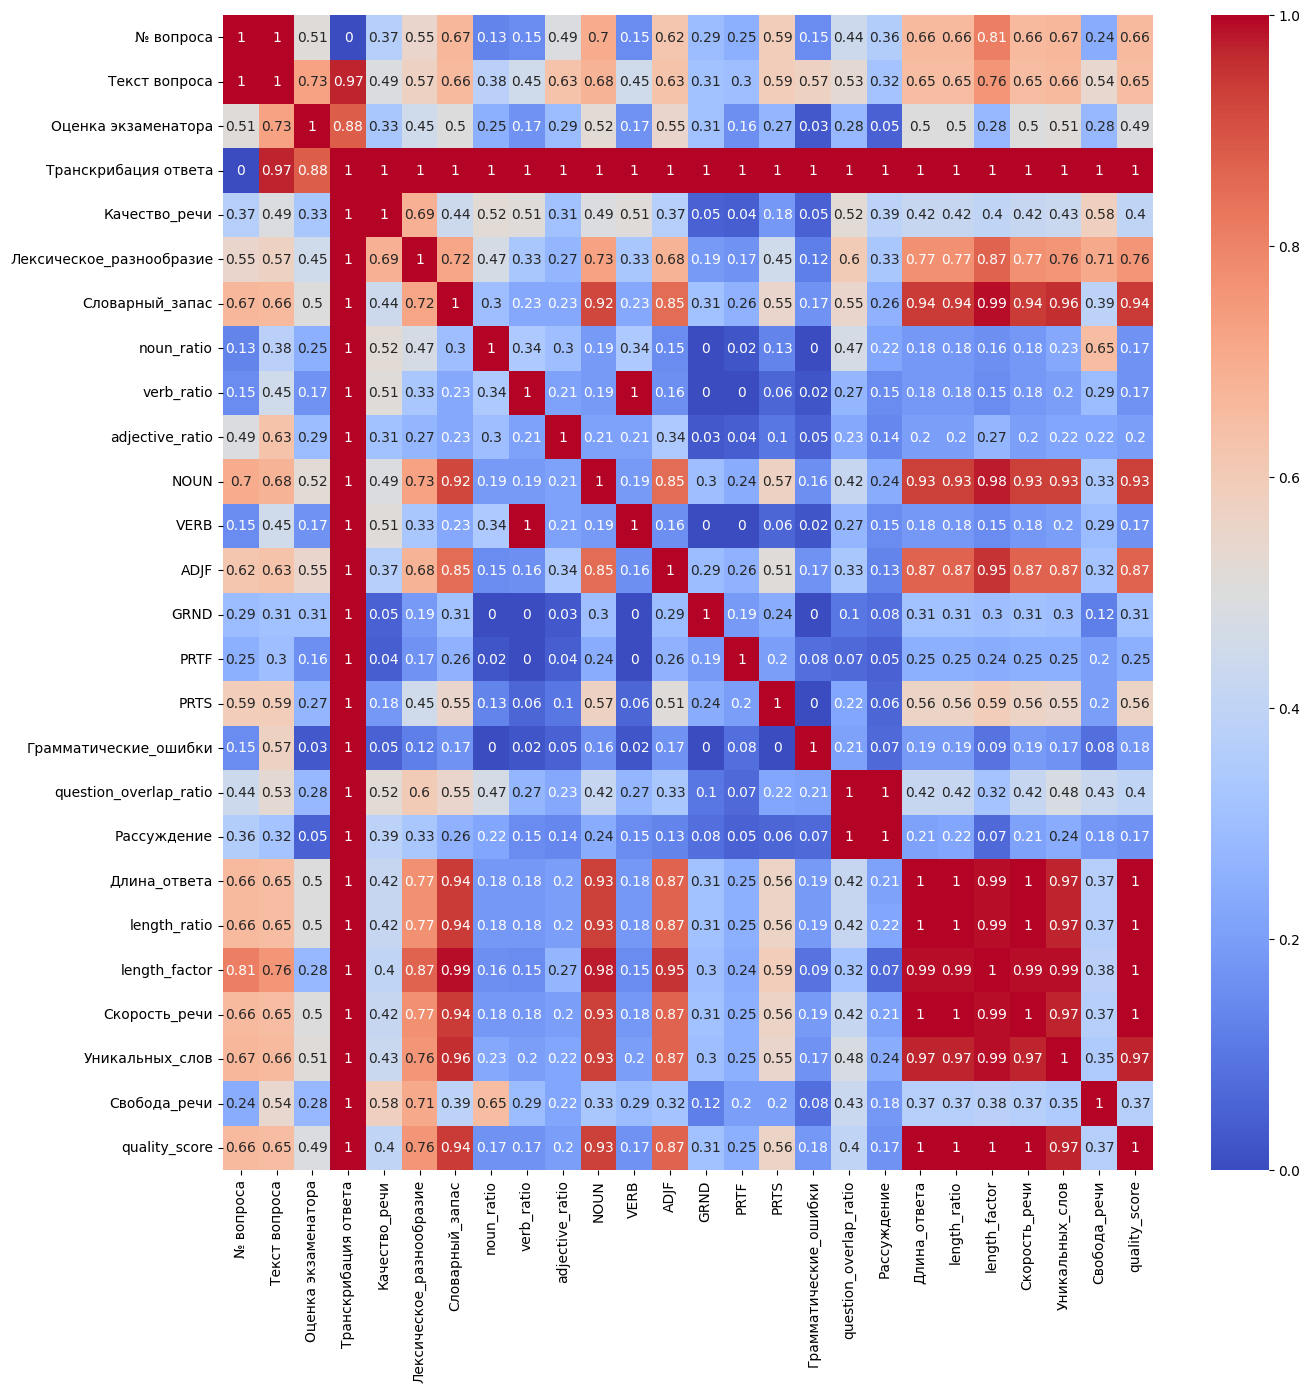

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(phik_corr.round(2), annot=True, cmap='coolwarm')
plt.show()

Оставим только корреляции с целевым признаком более 0.45

In [ ]:
# Выбираем признаки с высокой корреляцией с целевым
target_col = 'Оценка экзаменатора'
threshold = 0.45

# Получаем корреляции с целевым признаком
target_correlations = phik_corr.loc[target_col].abs()

# Выбираем признаки выше порога (исключая сам целевой)
strong_features = target_correlations[
    (target_correlations >= threshold) & 
    (target_correlations.index != target_col)
].index.tolist()

print(f"Признаки с корреляцией >{threshold} с целевым:")
for feature in strong_features:
    corr_value = target_correlations[feature]
    print(f"{feature}: {corr_value:.2f}")

print(f"\nВсего отобрано признаков: {len(strong_features)}")

Признаки с корреляцией >0.44 с целевым:
№ вопроса: 0.51
Текст вопроса: 0.73
Транскрибация ответа: 0.88
Лексическое_разнообразие: 0.45
Словарный_запас: 0.50
NOUN: 0.52
ADJF: 0.55
Длина_ответа: 0.50
length_ratio: 0.50
Скорость_речи: 0.50
Уникальных_слов: 0.51
quality_score: 0.49

Всего отобрано признаков: 12


In [ ]:
strong_features

['№ вопроса',
 'Текст вопроса',
 'Транскрибация ответа',
 'Словарный_запас',
 'NOUN',
 'ADJF',
 'Длина_ответа',
 'length_ratio',
 'Скорость_речи',
 'Уникальных_слов',
 'quality_score']

оставить только эти столбцы в датафрейме и проверить насколько изменились показатели моделей стали ли они выше


сейчас с колонками: ['№ вопроса', 'Текст вопроса', 'Оценка экзаменатора',
       'Транскрибация ответа', 'Длина_файла', 'Качество_речи',
       'Лексическое_разнообразие', 'Словарный_запас', 'noun_ratio',
       'verb_ratio', 'adjective_ratio', 'NOUN', 'VERB', 'ADJF', 'GRND', 'PRTF',
       'PRTS', 'Грамматические_ошибки', 'question_overlap_ratio',
       'Рассуждение', 'Длина_ответа', 'length_ratio', 'length_factor',
       'Скорость_речи', 'Уникальных_слов', 'Свобода_речи', 'quality_score']

корреляции:
№ вопроса	Текст вопроса	Оценка экзаменатора	Транскрибация ответа	Качество_речи	Лексическое_разнообразие	Словарный_запас	noun_ratio	verb_ratio	adjective_ratio	NOUN	VERB	ADJF	GRND	PRTF	PRTS	Грамматические_ошибки	question_overlap_ratio	Рассуждение	Длина_ответа	length_ratio	length_factor	Скорость_речи	Уникальных_слов	Свобода_речи	quality_score
0.51	0.73	1.00	0.88	0.33	0.45	0.50	0.25	0.17	0.29	0.52	0.17	0.55	0.31	0.16	0.27	0.03	0.28	0.05	0.50	0.50	0.28	0.50	0.51	0.28	0.49

Обучение RandomForest...
RandomForest: best_score 0.749
Точность test (accuracy): 0.733 (73.3%)
f1_score: 0.7276843075995053
 
 Лучшие параметры: {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 14, 'n_estimators': 65}


Обучение LogisticRegression...
LogisticRegression: best_score 0.763
Точность test (accuracy): 0.757 (75.7%)
f1_score: 0.7472098641383248
 
 Лучшие параметры: {'C': 8, 'max_iter': 39, 'penalty': 'l2', 'solver': 'liblinear'}


Обучение SVM...

оставляем в df выбранные признаки с высокой корреляцией

In [190]:
df = df[df['№ вопроса',
 'Текст вопроса',
 'Оценка экзаменатора'
 'Транскрибация ответа',
 'Словарный_запас',
 'NOUN',
 'ADJF',
 'Длина_ответа',
 'length_ratio',
 'Скорость_речи',
 'Уникальных_слов',
 'quality_score']]

df

KeyError: ('№ вопроса', 'Текст вопроса', 'Оценка экзаменатораТранскрибация ответа', 'Словарный_запас', 'NOUN', 'ADJF', 'Длина_ответа', 'length_ratio', 'Скорость_речи', 'Уникальных_слов', 'quality_score')

разделить датасет на выборки

In [ ]:
X = df.drop(['Оценка экзаменатора'], axis=1)
y = df['Оценка экзаменатора']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [ ]:
# Диагностика размеров
print("Размеры данных:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {len(y_train)}\n")

print(f"X_test: {X_test.shape}")
print(f"y_test: {len(y_test)}")

Размеры данных:
X_train: (7832, 26)
y_train: 7832

X_test: (1959, 26)
y_test: 1959


In [ ]:
# def check_data_leakage(train_df, test_df, id_col='id'):
#     """Проверка выборок на утечку данных"""
    
#     print("🔍 ПРОВЕРКА НА УТЕЧКУ ДАННЫХ")
#     print("=" * 50)
    
#     # 1. Проверка пересечения ID
#     train_ids = set(train_df[id_col])
#     test_ids = set(test_df[id_col])
    
#     common_ids = train_ids & test_ids
    
#     print(f"📊 Размеры выборок:")
#     print(f"   Train: {len(train_ids)} уникальных ID")
#     print(f"   Test:  {len(test_ids)} уникальных ID")
#     print(f"   Пересечение: {len(common_ids)} ID")
    
#     # 2. Основная проверка
#     if len(common_ids) > 0:
#         print(f"🚨 УТЕЧКА ОБНАРУЖЕНА! {len(common_ids)} общих ID")
#         print(f"   Примеры: {list(common_ids)[:5]}")
#         return print("\n⚠️  НЕОБХОДИМО ИСПРАВИТЬ УТЕЧКУ!")
#     else:
#         print("✅ УТЕЧКИ НЕТ - ID не пересекаются")
    
#     # 3. Дополнительные проверки
#     print(f"\n📈 Дополнительная статистика:")
#     print(f"   Покрытие: {len(train_ids | test_ids)} всего уникальных ID")
#     print(f"   Доля train: {len(train_ids)/(len(train_ids | test_ids)):.1%}")
#     print(f"   Доля test:  {len(test_ids)/(len(train_ids | test_ids)):.1%}")
    
#     return print("\n🎯 Выборки готовы к обучению")

# check_data_leakage(X_train, X_test)
    

In [ ]:

# numeric_features = X_train.select_dtypes(include=[np.number]).columns
numeric_features = ['№ вопроса',
 'Словарный_запас',
 'NOUN',
 'ADJF',
 'Длина_ответа',
 'length_ratio',
 'Скорость_речи',
 'Уникальных_слов',
 'quality_score']

Index(['№ вопроса', 'Длина_файла', 'Качество_речи', 'Лексическое_разнообразие',
       'Словарный_запас', 'noun_ratio', 'verb_ratio', 'adjective_ratio',
       'NOUN', 'VERB', 'ADJF', 'GRND', 'PRTF', 'PRTS', 'Грамматические_ошибки',
       'question_overlap_ratio', 'Рассуждение', 'Длина_ответа', 'length_ratio',
       'length_factor', 'Скорость_речи', 'Уникальных_слов', 'Свобода_речи',
       'quality_score'],
      dtype='object')

теперь надо создать пайплайн категорировать и масштабировать признаки

In [ ]:
X_train.columns

Index(['№ вопроса', 'Текст вопроса', 'Транскрибация ответа', 'Длина_файла',
       'Качество_речи', 'Лексическое_разнообразие', 'Словарный_запас',
       'noun_ratio', 'verb_ratio', 'adjective_ratio', 'NOUN', 'VERB', 'ADJF',
       'GRND', 'PRTF', 'PRTS', 'Грамматические_ошибки',
       'question_overlap_ratio', 'Рассуждение', 'Длина_ответа', 'length_ratio',
       'length_factor', 'Скорость_речи', 'Уникальных_слов', 'Свобода_речи',
       'quality_score'],
      dtype='object')

In [ ]:
#пайплайн для масштабирования и кодировки с использованием ColumnTransformer

# распределим колонки по типам переменных
numeric_features = ['№ вопроса',
 'Лексическое_разнообразие',
 'Словарный_запас',
 'NOUN',
 'ADJF',
 'Длина_ответа',
 'length_ratio',
 'Скорость_речи',
 'Уникальных_слов',
 'quality_score', # отобранные с корреляцией выше 0.45
 
 'length_quality', 'question_vocab', 'vocab_adjf' # Feature enginering усиленные
 ]

# ['Длина_файла',
#        'Качество_речи', 'Лексическое_разнообразие', 'Словарный_запас',
#        'noun_ratio', 'verb_ratio', 'adjective_ratio', 'NOUN', 'VERB', 'ADJF',
#        'GRND', 'PRTF', 'PRTS', 'Грамматические_ошибки',
#        'question_overlap_ratio', 'Рассуждение', 'Длина_ответа', 'length_ratio',
#        'length_factor', 'Скорость_речи', 'Уникальных_слов', 'Свобода_речи',
#        'quality_score', 
#        'length_quality', 'question_vocab', 'vocab_adjf']

categorical_features = ['№ вопроса']
text_features = ['Текст вопроса', 'Транскрибация ответа']

preprocessor = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='median'), numeric_features),
        ('num', StandardScaler(), numeric_features),
        
        # Упрощенная версия для текста
        ('text_answer', TfidfVectorizer(max_features=250), 'Транскрибация ответа'),
        ('text_question', TfidfVectorizer(max_features=250), 'Текст вопроса'),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'  # Удаляем неиспользуемые колонки
)

preprocessor

,transformers,"[('imputer', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [ ]:
# Создаем полный Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(f_classif, k=20)), 
    ('classifier', RandomForestClassifier())
])

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"Размеры массивов в preprocessor:")
for i, (name, transformer, columns) in enumerate(preprocessor.transformers):
    if hasattr(transformer, 'fit_transform'):
        try:
            result = transformer.fit_transform(X_train[columns])
            print(f"{name}: {result.shape}")
        except:
            print(f"{name}: ошибка трансформации")

X_train shape: (7832, 26)
Размеры массивов в preprocessor:
imputer: (7832, 23)
num: (7832, 23)
text_answer: (7832, 250)
cat: (7832, 3)


In [ ]:
X_train_procceed = preprocessor.fit_transform(X_train)
X_test_procceed  = preprocessor.transform(X_test)

RANDOM_STATE=42

scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

создать сетку грид search и сделать кросс валидацию

надо выести фик матрикс и посмотреть фажные признаки и пермутатион импотанс

In [ ]:
# Создание сетки моделей с параметрами
models = {
    'RandomForest': {
            'model': RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE),
            'params': { # сильно увеличивает время
                            'max_depth': [11, 12, 13],   
                            'max_features': ['sqrt', 'log2'],                            
                            'criterion': ['gini', 'entropy'],
                            'min_samples_leaf': [1, 2, 3],
                            'min_samples_split': [10, 11, 12, 13, 14, 15],       
                            'n_estimators': [55, 60, 65, 70]                          
                        }
    },
    
    'LogisticRegression': {
                'model': LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000),
                'params': {
                            'C': [5, 6, 7, 8, 9],
                            'solver': ['liblinear', 'lbfgs'],
                            'penalty': ['l1', 'l2'],
                            'max_iter': [36, 38, 39, 40]
                        },
    },
    
    'SVM': {
        'model': SVC(class_weight='balanced', random_state=42, probability=True),
        'params': {  # У SVC добавлен probability=True для корректной работы с ROC-AUC
                            'C': [10, 11, 12], # регуляризация, чем больше, тем сильнее штраф
                            'kernel': ['rbf', 'linear', 'poly'],
                            'gamma': ['scale', 'auto', 0.07, 0.06, 0.04, 0.03]
                        }
    },
    
    'GradientBoosting': {
                'model': GradientBoostingClassifier(random_state=RANDOM_STATE),
                'params': {
                        'n_estimators': [60, 62, 65, 67, 70],
                        'learning_rate': [0.1, 0.11, 0.12, 0.13, 0.15], 
                        'max_depth': [2, 3, 4]
        }    }}

In [ ]:
# Запуск GridSearchCV
best_models = {}
model_scores = {}

for name, config_params in models.items():
    print(f"\nОбучение {name}...")
    
    # GridSearchCV с вашими параметрами
    grid_search = GridSearchCV(
        config_params['model'], 
        config_params['params'],  # Используем ваши параметры напрямую
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train_procceed, y_train)  # Используем обработанные данные
    y_pred = grid_search.predict(X_test_procceed)
    
    best_models[name] = grid_search.best_estimator_
    accuracy = accuracy_score(y_test, y_pred)
    model_scores[name] = accuracy
    
    print(f"{name}: best_score {grid_search.best_score_:.3f}")
    print(f"Точность test (accuracy): {accuracy:.3f} ({accuracy*100:.1f}%)")
    print(f"f1_score: {f1_score(y_test, y_pred, average='weighted')}")
    print(f" \n Лучшие параметры: {grid_search.best_params_}")
    print()


Обучение RandomForest...
RandomForest: best_score 0.749
Точность test (accuracy): 0.733 (73.3%)
f1_score: 0.7276843075995053
 
 Лучшие параметры: {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 14, 'n_estimators': 65}


Обучение LogisticRegression...
LogisticRegression: best_score 0.763
Точность test (accuracy): 0.757 (75.7%)
f1_score: 0.7472098641383248
 
 Лучшие параметры: {'C': 8, 'max_iter': 39, 'penalty': 'l2', 'solver': 'liblinear'}


Обучение SVM...


KeyboardInterrupt: 

Подберем оптимальный порог в классификации при трех значениях

In [ ]:
# После выбора лучшей модели
best_model_name = max(model_scores, key=model_scores.get)
final_best_model = best_models[best_model_name]

In [ ]:
print(type(final_best_model))
print(final_best_model)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
GradientBoostingClassifier(learning_rate=0.11, max_depth=4, n_estimators=65,
                           random_state=42)


* Если увидите Pipeline, используйте X_train.

* Если увидите RandomForestClassifier или другой классификатор, используйте X_train_procceed.

In [ ]:
def predict_with_thresholds(proba, threshold_0, threshold_1):
    """Применяет найденные пороги для получения финальных предсказаний"""
    predictions = np.zeros(len(proba))
    
    # Шаг 1: Если вероятность класса 0 > порога, присваиваем класс 0
    predictions[proba[:, 0] > threshold_0] = 0
    
    # Шаг 2: Среди оставшихся разделяем классы 1 и 2
    remaining_mask = proba[:, 0] <= threshold_0
    remaining_proba = proba[remaining_mask]
    
    # Класс 1 если вероятность > порога, иначе класс 2
    predictions[remaining_mask] = np.where(
        remaining_proba[:, 1] > threshold_1, 1, 2
    )
    
    return predictions.astype(int)


# Найти пороги на train
proba_cv = cross_val_predict(final_best_model, X_train_procceed, y_train, cv=5, method='predict_proba')

# Порог для класса 0
best_score_0 = 0
threshold_0 = 0.33
for t in np.arange(0.1, 0.9, 0.01):
    pred_0 = (proba_cv[:, 0] > t).astype(int)
    score = f1_score(y_train == 0, pred_0)
    if score > best_score_0:
        best_score_0 = score
        threshold_0 = t

# Порог для класса 1
mask = y_train != 0
best_score_1 = 0
threshold_1 = 0.5
for t in np.arange(0.1, 0.9, 0.01):
    pred_1 = (proba_cv[mask, 1] > t).astype(int)
    score = f1_score(y_train[mask] == 1, pred_1)
    if score > best_score_1:
        best_score_1 = score
        threshold_1 = t



print(f"порог для класса 0: от 0 до порога {threshold_0}")
print(f"порог для класса 1: от {threshold_0} до порога {threshold_1}")
print(f"порог для класса 2: от {threshold_1} до 1")

# Применить на test
proba_test = final_best_model.predict_proba(X_test_procceed)
y_pred_optimized = predict_with_thresholds(proba_test, threshold_0, threshold_1)

# Сравнить результаты
print("Без оптимизации порогов:")
print(f"Accuracy: {accuracy_score(y_test, final_best_model.predict(X_test_procceed)):.3f}")
print(f"F1-macro: {f1_score(y_test, final_best_model.predict(X_test_procceed), average='macro'):.3f}")

print("\nС оптимизированными порогами:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.3f}")
print(f"F1-macro: {f1_score(y_test, y_pred_optimized, average='macro'):.3f}")


порог для класса 0: от 0 до порога 0.19999999999999996
порог для класса 1: от 0.19999999999999996 до порога 0.3599999999999999
порог для класса 2: от 0.3599999999999999 до 1
Без оптимизации порогов:
Accuracy: 0.775
F1-macro: 0.634

С оптимизированными порогами:
Accuracy: 0.726
F1-macro: 0.671
